In [1]:
import numpy as np
from tqdm import tqdm
import boto3
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from models import MobileNetV3
from models import ViT

from data_preparation import CreateDataset, load_images_and_labels, encode_labels, create_data_augmentation
from trainer import prune_model, remove_pruning, count_nonzero_parameters, store_pruning_masks, reapply_pruning_masks, evaluate_model, plot_losses

import pickle
import multiprocessing

num_workers = multiprocessing.cpu_count()

batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = "fer2013"

bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [3]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [4]:
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)

label_encoder_dir = f'{data}/models'
label_encoder_path = f'final_label_encoder_{data}.pkl'

with open(label_encoder_path, 'wb') as file:
    pickle.dump(label_encoder, file)

s3 = boto3.client('s3')
s3.upload_file(label_encoder_path, bucket_name, os.path.join(label_encoder_dir, label_encoder_path))

os.remove(label_encoder_path)

In [5]:
transform = create_data_augmentation()

train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [6]:
student_model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
teacher_model = ViT(num_labels=len(label_encoder.classes_)).to(device)

teacher_model.load_state_dict(torch.load(f'vit_{data}_best_model.pt',weights_only=False))

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.0001)

In [ ]:
def train_model(teacher,
                student,
                train_loader,
                val_loader,
                criterion,
                optimizer,
                epochs,
                device="cpu",
                prune_percent=0.2,
                total_prune_cycles=100,
                patience=10,
                cycle_patience=3,
                T=2,
                soft_target_loss_weight=0.25,
                ce_loss_weight=0.75):

    best_models_dict = {}
    best_model_wts = copy.deepcopy(student.state_dict())
    global_best_val_loss = np.inf
    train_losses = []
    val_losses = []

    initial_params = count_nonzero_parameters(student)
    print(f"Initial non-zero parameters: {initial_params}")

    no_improvement_cycles = 0

    for cycle in range(total_prune_cycles):
        print(f"Pruning cycle {cycle + 1}/{total_prune_cycles}")

        current_params = count_nonzero_parameters(student)
        print(f"Params before cycle {cycle + 1}: {current_params}")

        cycle_best_val_loss = np.inf
        cycle_best_model_wts = copy.deepcopy(student.state_dict())
        no_improvement_epochs = 0

        for epoch in range(epochs):
            student.train()
            total_train_loss = 0

            for images, labels in tqdm(train_loader, desc=f"Cycle {cycle + 1}, Epoch {epoch + 1}"):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.no_grad():
                    teacher_logits = teacher(images).logits

                student_logits = student(images)

                soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
                soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

                soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

                label_loss = criterion(student_logits, labels)

                loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss
                loss.backward()
                
                for name, param in student.named_parameters():
                    if hasattr(param, 'mask'):
                        param.grad *= param.mask
                        
                optimizer.step()

                total_train_loss += loss.item()

                del images, labels, student_logits, loss, teacher_logits
                torch.cuda.empty_cache()

            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            student.eval()
            total_val_loss = 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = student(images)
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item()

                    del images, labels, outputs, loss
                    torch.cuda.empty_cache()

            avg_val_loss = total_val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

            if avg_val_loss < cycle_best_val_loss:
                cycle_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(student)
                remove_pruning(student)
                cycle_best_model_wts = copy.deepcopy(student.state_dict())
                reapply_pruning_masks(student, pruning_masks)
                
                no_improvement_epochs = 0
            else:
                no_improvement_epochs += 1

            if avg_val_loss < global_best_val_loss:
                global_best_val_loss = avg_val_loss
                pruning_masks = store_pruning_masks(student)
                remove_pruning(student)
                best_model_wts = copy.deepcopy(student.state_dict())
                reapply_pruning_masks(student, pruning_masks)

            if no_improvement_epochs >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1} of cycle {cycle + 1}")
                break

        print(f"Cycle best loss: {cycle_best_val_loss}")
        print(f"Global best loss: {global_best_val_loss}")
        if cycle_best_val_loss == global_best_val_loss:
            global_best_val_loss = cycle_best_val_loss
            no_improvement_cycles = 0
            print(f"New global best validation loss: {global_best_val_loss:.4f} at cycle {cycle + 1}")
        else:
            no_improvement_cycles += 1
            print(f"No improvement in cycle {cycle + 1}. Cycle patience: {no_improvement_cycles}/{cycle_patience}")

        if no_improvement_cycles >= cycle_patience:
            print(f"Early stopping after {cycle + 1} cycles with no improvement.")
            break

        pruning_masks = store_pruning_masks(student)
        remove_pruning(student)
        
        student.load_state_dict(cycle_best_model_wts)
            
        best_models_dict[cycle + 1] = {
            'cycle': cycle + 1,
            'model': copy.deepcopy(student.state_dict()),
            'params': count_nonzero_parameters(student),
            'min_val_loss': cycle_best_val_loss
        }
        
        reapply_pruning_masks(student, pruning_masks)
        
        try:

            prune_model(student, prune_percent)
        except:
            print("Achieved max amount for pruning")
            current_params = count_nonzero_parameters(student)
            print(f"Parameters after cycle {cycle + 1}: {current_params}")
            break

        current_params = count_nonzero_parameters(student)
        print(f"Parameters after cycle {cycle + 1}: {current_params}")

    remove_pruning(student)
    student.load_state_dict(best_model_wts)

    final_params = count_nonzero_parameters(student)
    print(f"Best model count of paramenters: {final_params}")

    return student, best_models_dict, train_losses, val_losses

best_model, best_models_dict, train_loss, val_loss = train_model(
                                    teacher=teacher_model,
                                    student=student_model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=10,
                                    cycle_patience=10,
                                    prune_percent=0.1,
                                    total_prune_cycles=20,
                                    T=8)

Initial non-zero parameters: 1515056
Pruning cycle 1/20
Params before cycle 1: 1515056


Cycle 1, Epoch 1: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 1, Train Loss: 1.4366, Validation Loss: 1.3218


Cycle 1, Epoch 2: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 2, Train Loss: 1.1582, Validation Loss: 1.1832


Cycle 1, Epoch 3: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 3, Train Loss: 1.0576, Validation Loss: 1.1325


Cycle 1, Epoch 4: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 4, Train Loss: 0.9955, Validation Loss: 1.0884


Cycle 1, Epoch 5: 100%|██████████| 561/561 [03:22<00:00,  2.77it/s]


Epoch 5, Train Loss: 0.9487, Validation Loss: 1.0684


Cycle 1, Epoch 6: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 6, Train Loss: 0.9071, Validation Loss: 1.0463


Cycle 1, Epoch 7: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 7, Train Loss: 0.8727, Validation Loss: 1.0366


Cycle 1, Epoch 8: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 8, Train Loss: 0.8465, Validation Loss: 1.0191


Cycle 1, Epoch 9: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 9, Train Loss: 0.8163, Validation Loss: 1.0146


Cycle 1, Epoch 10: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 10, Train Loss: 0.7914, Validation Loss: 1.0157


Cycle 1, Epoch 11: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 11, Train Loss: 0.7662, Validation Loss: 1.0107


Cycle 1, Epoch 12: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 12, Train Loss: 0.7431, Validation Loss: 1.0194


Cycle 1, Epoch 13: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 13, Train Loss: 0.7193, Validation Loss: 1.0215


Cycle 1, Epoch 14: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 14, Train Loss: 0.7021, Validation Loss: 1.0024


Cycle 1, Epoch 15: 100%|██████████| 561/561 [03:19<00:00,  2.82it/s]


Epoch 15, Train Loss: 0.6783, Validation Loss: 1.0257


Cycle 1, Epoch 16: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 16, Train Loss: 0.6576, Validation Loss: 1.0269


Cycle 1, Epoch 17: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 17, Train Loss: 0.6414, Validation Loss: 1.0100


Cycle 1, Epoch 18: 100%|██████████| 561/561 [03:19<00:00,  2.82it/s]


Epoch 18, Train Loss: 0.6186, Validation Loss: 1.0255


Cycle 1, Epoch 19: 100%|██████████| 561/561 [03:19<00:00,  2.82it/s]


Epoch 19, Train Loss: 0.6032, Validation Loss: 1.0342


Cycle 1, Epoch 20: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 20, Train Loss: 0.5827, Validation Loss: 1.0272


Cycle 1, Epoch 21: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 21, Train Loss: 0.5648, Validation Loss: 1.0490


Cycle 1, Epoch 22: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 22, Train Loss: 0.5458, Validation Loss: 1.0394


Cycle 1, Epoch 23: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 23, Train Loss: 0.5364, Validation Loss: 1.0491


Cycle 1, Epoch 24: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 24, Train Loss: 0.5146, Validation Loss: 1.0388
Early stopping triggered at epoch 24 of cycle 1
Cycle best loss: 1.0024310012092794
Global best loss: 1.0024310012092794
New global best validation loss: 1.0024 at cycle 1
Parameters after cycle 1: 1364157
Pruning cycle 2/20
Params before cycle 2: 1364157


Cycle 2, Epoch 1: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 1, Train Loss: 0.6772, Validation Loss: 1.0058


Cycle 2, Epoch 2: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 2, Train Loss: 0.6625, Validation Loss: 1.0198


Cycle 2, Epoch 3: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 3, Train Loss: 0.6339, Validation Loss: 1.0236


Cycle 2, Epoch 4: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 4, Train Loss: 0.6247, Validation Loss: 1.0203


Cycle 2, Epoch 5: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 5, Train Loss: 0.6062, Validation Loss: 1.0231


Cycle 2, Epoch 6: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 6, Train Loss: 0.5934, Validation Loss: 1.0188


Cycle 2, Epoch 7: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 7, Train Loss: 0.5745, Validation Loss: 1.0263


Cycle 2, Epoch 8: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 8, Train Loss: 0.5578, Validation Loss: 1.0585


Cycle 2, Epoch 9: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 9, Train Loss: 0.5415, Validation Loss: 1.0481


Cycle 2, Epoch 10: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 10, Train Loss: 0.5259, Validation Loss: 1.0433


Cycle 2, Epoch 11: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 11, Train Loss: 0.5140, Validation Loss: 1.0538
Early stopping triggered at epoch 11 of cycle 2
Cycle best loss: 1.0057901907645934
Global best loss: 1.0024310012092794
No improvement in cycle 2. Cycle patience: 1/10
Parameters after cycle 2: 1228348
Pruning cycle 3/20
Params before cycle 3: 1228348


Cycle 3, Epoch 1: 100%|██████████| 561/561 [03:21<00:00,  2.78it/s]


Epoch 1, Train Loss: 0.6631, Validation Loss: 1.0190


Cycle 3, Epoch 2: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 2, Train Loss: 0.6434, Validation Loss: 1.0224


Cycle 3, Epoch 3: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 3, Train Loss: 0.6265, Validation Loss: 1.0264


Cycle 3, Epoch 4: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 4, Train Loss: 0.6120, Validation Loss: 1.0234


Cycle 3, Epoch 5: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 5, Train Loss: 0.5926, Validation Loss: 1.0306


Cycle 3, Epoch 6: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 6, Train Loss: 0.5819, Validation Loss: 1.0260


Cycle 3, Epoch 7: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 7, Train Loss: 0.5610, Validation Loss: 1.0477


Cycle 3, Epoch 8: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 8, Train Loss: 0.5470, Validation Loss: 1.0329


Cycle 3, Epoch 9: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 9, Train Loss: 0.5347, Validation Loss: 1.0522


Cycle 3, Epoch 10: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 10, Train Loss: 0.5184, Validation Loss: 1.0315


Cycle 3, Epoch 11: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 11, Train Loss: 0.5118, Validation Loss: 1.0485
Early stopping triggered at epoch 11 of cycle 3
Cycle best loss: 1.0190195319279234
Global best loss: 1.0024310012092794
No improvement in cycle 3. Cycle patience: 2/10
Parameters after cycle 3: 1106117
Pruning cycle 4/20
Params before cycle 4: 1106117


Cycle 4, Epoch 1: 100%|██████████| 561/561 [03:21<00:00,  2.78it/s]


Epoch 1, Train Loss: 0.6614, Validation Loss: 1.0118


Cycle 4, Epoch 2: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 2, Train Loss: 0.6364, Validation Loss: 1.0232


Cycle 4, Epoch 3: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 3, Train Loss: 0.6209, Validation Loss: 1.0242


Cycle 4, Epoch 4: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 4, Train Loss: 0.5997, Validation Loss: 1.0336


Cycle 4, Epoch 5: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 5, Train Loss: 0.5910, Validation Loss: 1.0323


Cycle 4, Epoch 6: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 6, Train Loss: 0.5743, Validation Loss: 1.0263


Cycle 4, Epoch 7: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 7, Train Loss: 0.5585, Validation Loss: 1.0463


Cycle 4, Epoch 8: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 8, Train Loss: 0.5496, Validation Loss: 1.0517


Cycle 4, Epoch 9: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 9, Train Loss: 0.5365, Validation Loss: 1.0401


Cycle 4, Epoch 10: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 10, Train Loss: 0.5266, Validation Loss: 1.0515


Cycle 4, Epoch 11: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 11, Train Loss: 0.5104, Validation Loss: 1.0588
Early stopping triggered at epoch 11 of cycle 4
Cycle best loss: 1.0117885257213566
Global best loss: 1.0024310012092794
No improvement in cycle 4. Cycle patience: 3/10
Parameters after cycle 4: 996107
Pruning cycle 5/20
Params before cycle 5: 996107


Cycle 5, Epoch 1: 100%|██████████| 561/561 [03:22<00:00,  2.77it/s]


Epoch 1, Train Loss: 0.6778, Validation Loss: 1.0207


Cycle 5, Epoch 2: 100%|██████████| 561/561 [03:19<00:00,  2.81it/s]


Epoch 2, Train Loss: 0.6397, Validation Loss: 1.0199


Cycle 5, Epoch 3: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 3, Train Loss: 0.6216, Validation Loss: 1.0237


Cycle 5, Epoch 4: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 4, Train Loss: 0.6072, Validation Loss: 1.0213


Cycle 5, Epoch 5: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 5, Train Loss: 0.5895, Validation Loss: 1.0427


Cycle 5, Epoch 6: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 6, Train Loss: 0.5785, Validation Loss: 1.0418


Cycle 5, Epoch 7: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 7, Train Loss: 0.5640, Validation Loss: 1.0425


Cycle 5, Epoch 8: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 8, Train Loss: 0.5490, Validation Loss: 1.0462


Cycle 5, Epoch 9: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 9, Train Loss: 0.5363, Validation Loss: 1.0659


Cycle 5, Epoch 10: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 10, Train Loss: 0.5298, Validation Loss: 1.0490


Cycle 5, Epoch 11: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 11, Train Loss: 0.5185, Validation Loss: 1.0554


Cycle 5, Epoch 12: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 12, Train Loss: 0.5024, Validation Loss: 1.0595
Early stopping triggered at epoch 12 of cycle 5
Cycle best loss: 1.0199480427966
Global best loss: 1.0024310012092794
No improvement in cycle 5. Cycle patience: 4/10
Parameters after cycle 5: 897098
Pruning cycle 6/20
Params before cycle 6: 897098


Cycle 6, Epoch 1: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 1, Train Loss: 0.6745, Validation Loss: 1.0310


Cycle 6, Epoch 2: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 2, Train Loss: 0.6359, Validation Loss: 1.0323


Cycle 6, Epoch 3: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 3, Train Loss: 0.6155, Validation Loss: 1.0315


Cycle 6, Epoch 4: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 4, Train Loss: 0.6019, Validation Loss: 1.0313


Cycle 6, Epoch 5: 100%|██████████| 561/561 [03:21<00:00,  2.79it/s]


Epoch 5, Train Loss: 0.5838, Validation Loss: 1.0363


Cycle 6, Epoch 6: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 6, Train Loss: 0.5686, Validation Loss: 1.0385


Cycle 6, Epoch 7: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 7, Train Loss: 0.5555, Validation Loss: 1.0391


Cycle 6, Epoch 8: 100%|██████████| 561/561 [03:20<00:00,  2.79it/s]


Epoch 8, Train Loss: 0.5446, Validation Loss: 1.0438


Cycle 6, Epoch 9: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 9, Train Loss: 0.5364, Validation Loss: 1.0427


Cycle 6, Epoch 10: 100%|██████████| 561/561 [03:19<00:00,  2.82it/s]


Epoch 10, Train Loss: 0.5230, Validation Loss: 1.0458


Cycle 6, Epoch 11: 100%|██████████| 561/561 [03:18<00:00,  2.83it/s]


Epoch 11, Train Loss: 0.5154, Validation Loss: 1.0419
Early stopping triggered at epoch 11 of cycle 6
Cycle best loss: 1.030985942726882
Global best loss: 1.0024310012092794
No improvement in cycle 6. Cycle patience: 5/10
Parameters after cycle 6: 807994
Pruning cycle 7/20
Params before cycle 7: 807994


Cycle 7, Epoch 1: 100%|██████████| 561/561 [03:20<00:00,  2.80it/s]


Epoch 1, Train Loss: 0.7137, Validation Loss: 1.0402


Cycle 7, Epoch 2: 100%|██████████| 561/561 [03:18<00:00,  2.83it/s]


Epoch 2, Train Loss: 0.6646, Validation Loss: 1.0275


Cycle 7, Epoch 3: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 3, Train Loss: 0.6433, Validation Loss: 1.0281


Cycle 7, Epoch 4: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 4, Train Loss: 0.6216, Validation Loss: 1.0367


Cycle 7, Epoch 5: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 5, Train Loss: 0.6094, Validation Loss: 1.0417


Cycle 7, Epoch 6: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 6, Train Loss: 0.5955, Validation Loss: 1.0353


Cycle 7, Epoch 7: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 7, Train Loss: 0.5789, Validation Loss: 1.0363


Cycle 7, Epoch 8: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 8, Train Loss: 0.5673, Validation Loss: 1.0513


Cycle 7, Epoch 9: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 9, Train Loss: 0.5576, Validation Loss: 1.0423


Cycle 7, Epoch 10: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 10, Train Loss: 0.5446, Validation Loss: 1.0459


Cycle 7, Epoch 11: 100%|██████████| 561/561 [03:16<00:00,  2.85it/s]


Epoch 11, Train Loss: 0.5336, Validation Loss: 1.0508


Cycle 7, Epoch 12: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 12, Train Loss: 0.5191, Validation Loss: 1.0483
Early stopping triggered at epoch 12 of cycle 7
Cycle best loss: 1.0274513641710383
Global best loss: 1.0024310012092794
No improvement in cycle 7. Cycle patience: 6/10
Parameters after cycle 7: 727802
Pruning cycle 8/20
Params before cycle 8: 727802


Cycle 8, Epoch 1: 100%|██████████| 561/561 [03:19<00:00,  2.82it/s]


Epoch 1, Train Loss: 0.7424, Validation Loss: 1.0274


Cycle 8, Epoch 2: 100%|██████████| 561/561 [03:16<00:00,  2.85it/s]


Epoch 2, Train Loss: 0.6795, Validation Loss: 1.0230


Cycle 8, Epoch 3: 100%|██████████| 561/561 [03:17<00:00,  2.85it/s]


Epoch 3, Train Loss: 0.6567, Validation Loss: 1.0391


Cycle 8, Epoch 4: 100%|██████████| 561/561 [03:17<00:00,  2.85it/s]


Epoch 4, Train Loss: 0.6375, Validation Loss: 1.0393


Cycle 8, Epoch 5: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 5, Train Loss: 0.6172, Validation Loss: 1.0279


Cycle 8, Epoch 6: 100%|██████████| 561/561 [03:16<00:00,  2.85it/s]


Epoch 6, Train Loss: 0.6049, Validation Loss: 1.0403


Cycle 8, Epoch 7: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 7, Train Loss: 0.5938, Validation Loss: 1.0379


Cycle 8, Epoch 8: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 8, Train Loss: 0.5786, Validation Loss: 1.0412


Cycle 8, Epoch 9: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 9, Train Loss: 0.5701, Validation Loss: 1.0382


Cycle 8, Epoch 10: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 10, Train Loss: 0.5570, Validation Loss: 1.0491


Cycle 8, Epoch 11: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 11, Train Loss: 0.5466, Validation Loss: 1.0522


Cycle 8, Epoch 12: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 12, Train Loss: 0.5370, Validation Loss: 1.0575
Early stopping triggered at epoch 12 of cycle 8
Cycle best loss: 1.0230126616369364
Global best loss: 1.0024310012092794
No improvement in cycle 8. Cycle patience: 7/10
Parameters after cycle 8: 655622
Pruning cycle 9/20
Params before cycle 9: 655622


Cycle 9, Epoch 1: 100%|██████████| 561/561 [03:17<00:00,  2.84it/s]


Epoch 1, Train Loss: 0.7660, Validation Loss: 1.0357


Cycle 9, Epoch 2: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 2, Train Loss: 0.7055, Validation Loss: 1.0300


Cycle 9, Epoch 3: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 3, Train Loss: 0.6771, Validation Loss: 1.0284


Cycle 9, Epoch 4: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 4, Train Loss: 0.6583, Validation Loss: 1.0371


Cycle 9, Epoch 5: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 5, Train Loss: 0.6361, Validation Loss: 1.0372


Cycle 9, Epoch 6: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 6, Train Loss: 0.6267, Validation Loss: 1.0452


Cycle 9, Epoch 7: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 7, Train Loss: 0.6121, Validation Loss: 1.0273


Cycle 9, Epoch 8: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 8, Train Loss: 0.6032, Validation Loss: 1.0363


Cycle 9, Epoch 9: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 9, Train Loss: 0.5892, Validation Loss: 1.0374


Cycle 9, Epoch 10: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 10, Train Loss: 0.5738, Validation Loss: 1.0366


Cycle 9, Epoch 11: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 11, Train Loss: 0.5681, Validation Loss: 1.0391


Cycle 9, Epoch 12: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 12, Train Loss: 0.5541, Validation Loss: 1.0478


Cycle 9, Epoch 13: 100%|██████████| 561/561 [03:15<00:00,  2.88it/s]


Epoch 13, Train Loss: 0.5479, Validation Loss: 1.0430


Cycle 9, Epoch 14: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 14, Train Loss: 0.5388, Validation Loss: 1.0530


Cycle 9, Epoch 15: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 15, Train Loss: 0.5322, Validation Loss: 1.0646


Cycle 9, Epoch 16: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 16, Train Loss: 0.5198, Validation Loss: 1.0700


Cycle 9, Epoch 17: 100%|██████████| 561/561 [03:14<00:00,  2.88it/s]


Epoch 17, Train Loss: 0.5149, Validation Loss: 1.0519
Early stopping triggered at epoch 17 of cycle 9
Cycle best loss: 1.027322321812029
Global best loss: 1.0024310012092794
No improvement in cycle 9. Cycle patience: 8/10
Parameters after cycle 9: 590669
Pruning cycle 10/20
Params before cycle 10: 590669


Cycle 10, Epoch 1: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 1, Train Loss: 0.7349, Validation Loss: 1.0632


Cycle 10, Epoch 2: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 2, Train Loss: 0.6618, Validation Loss: 1.0491


Cycle 10, Epoch 3: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 3, Train Loss: 0.6249, Validation Loss: 1.0410


Cycle 10, Epoch 4: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 4, Train Loss: 0.6121, Validation Loss: 1.0420


Cycle 10, Epoch 5: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 5, Train Loss: 0.5924, Validation Loss: 1.0527


Cycle 10, Epoch 6: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 6, Train Loss: 0.5794, Validation Loss: 1.0462


Cycle 10, Epoch 7: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 7, Train Loss: 0.5656, Validation Loss: 1.0514


Cycle 10, Epoch 8: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 8, Train Loss: 0.5626, Validation Loss: 1.0561


Cycle 10, Epoch 9: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 9, Train Loss: 0.5486, Validation Loss: 1.0489


Cycle 10, Epoch 10: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 10, Train Loss: 0.5373, Validation Loss: 1.0589


Cycle 10, Epoch 11: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 11, Train Loss: 0.5268, Validation Loss: 1.0623


Cycle 10, Epoch 12: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 12, Train Loss: 0.5232, Validation Loss: 1.0593


Cycle 10, Epoch 13: 100%|██████████| 561/561 [03:16<00:00,  2.86it/s]


Epoch 13, Train Loss: 0.5127, Validation Loss: 1.0491
Early stopping triggered at epoch 13 of cycle 10
Cycle best loss: 1.0410319607028757
Global best loss: 1.0024310012092794
No improvement in cycle 10. Cycle patience: 9/10
Parameters after cycle 10: 532205
Pruning cycle 11/20
Params before cycle 11: 532205


Cycle 11, Epoch 1: 100%|██████████| 561/561 [03:16<00:00,  2.85it/s]


Epoch 1, Train Loss: 0.8047, Validation Loss: 1.0593


Cycle 11, Epoch 2: 100%|██████████| 561/561 [03:15<00:00,  2.88it/s]


Epoch 2, Train Loss: 0.7022, Validation Loss: 1.0488


Cycle 11, Epoch 3: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 3, Train Loss: 0.6683, Validation Loss: 1.0532


Cycle 11, Epoch 4: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 4, Train Loss: 0.6413, Validation Loss: 1.0471


Cycle 11, Epoch 5: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 5, Train Loss: 0.6251, Validation Loss: 1.0498


Cycle 11, Epoch 6: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 6, Train Loss: 0.6095, Validation Loss: 1.0468


Cycle 11, Epoch 7: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 7, Train Loss: 0.5996, Validation Loss: 1.0477


Cycle 11, Epoch 8: 100%|██████████| 561/561 [03:15<00:00,  2.86it/s]


Epoch 8, Train Loss: 0.5858, Validation Loss: 1.0429


Cycle 11, Epoch 9: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 9, Train Loss: 0.5761, Validation Loss: 1.0584


Cycle 11, Epoch 10: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 10, Train Loss: 0.5668, Validation Loss: 1.0629


Cycle 11, Epoch 11: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 11, Train Loss: 0.5574, Validation Loss: 1.0525


Cycle 11, Epoch 12: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 12, Train Loss: 0.5473, Validation Loss: 1.0668


Cycle 11, Epoch 13: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 13, Train Loss: 0.5361, Validation Loss: 1.0583


Cycle 11, Epoch 14: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 14, Train Loss: 0.5337, Validation Loss: 1.0665


Cycle 11, Epoch 15: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 15, Train Loss: 0.5209, Validation Loss: 1.0650


Cycle 11, Epoch 16: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 16, Train Loss: 0.5132, Validation Loss: 1.0706


Cycle 11, Epoch 17: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 17, Train Loss: 0.5091, Validation Loss: 1.0725


Cycle 11, Epoch 18: 100%|██████████| 561/561 [03:15<00:00,  2.87it/s]


Epoch 18, Train Loss: 0.5049, Validation Loss: 1.0651
Early stopping triggered at epoch 18 of cycle 11
Cycle best loss: 1.0429083840702775
Global best loss: 1.0024310012092794
No improvement in cycle 11. Cycle patience: 10/10
Early stopping after 11 cycles with no improvement.
Best model count of paramenters: 1515056


In [12]:
models_dict_dir = f'{data}/models'
models_dict_path = f'models_dict_{data}.pkl'

with open(models_dict_path, 'wb') as file:
    pickle.dump(best_models_dict, file)

s3 = boto3.client('s3')
s3.upload_file(models_dict_path, bucket_name, os.path.join(models_dict_dir, models_dict_path))

os.remove(models_dict_path)

Evaluating model from cycle 1, Parameters: 1515056, Min Val Loss: 1.0024


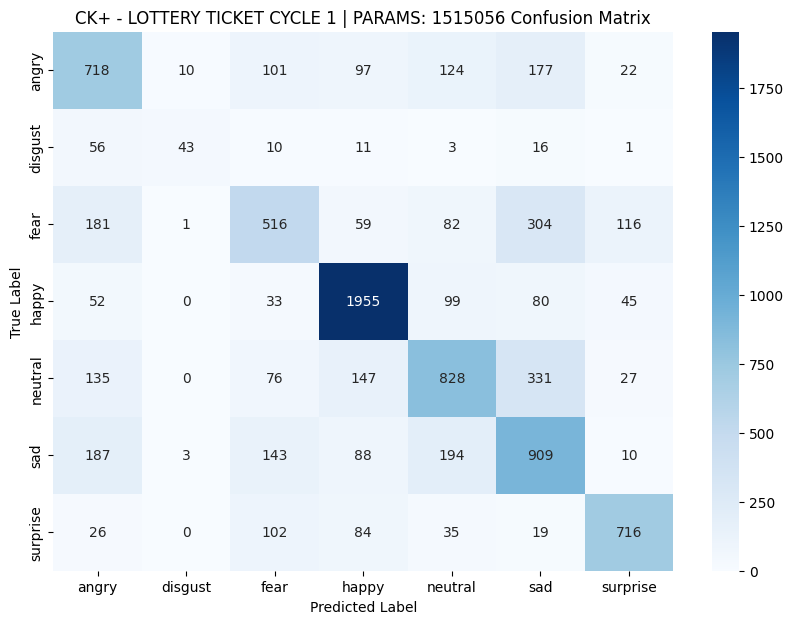

Test Accuracy: 0.6336
Precision: 0.6396
Recall: 0.5733
F1 Score: 0.5907
Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.57      0.55      1249
     disgust       0.75      0.31      0.44       140
        fear       0.53      0.41      0.46      1259
       happy       0.80      0.86      0.83      2264
     neutral       0.61      0.54      0.57      1544
         sad       0.50      0.59      0.54      1534
    surprise       0.76      0.73      0.75       982

    accuracy                           0.63      8972
   macro avg       0.64      0.57      0.59      8972
weighted avg       0.63      0.63      0.63      8972

Evaluating model from cycle 2, Parameters: 1364157, Min Val Loss: 1.0058


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


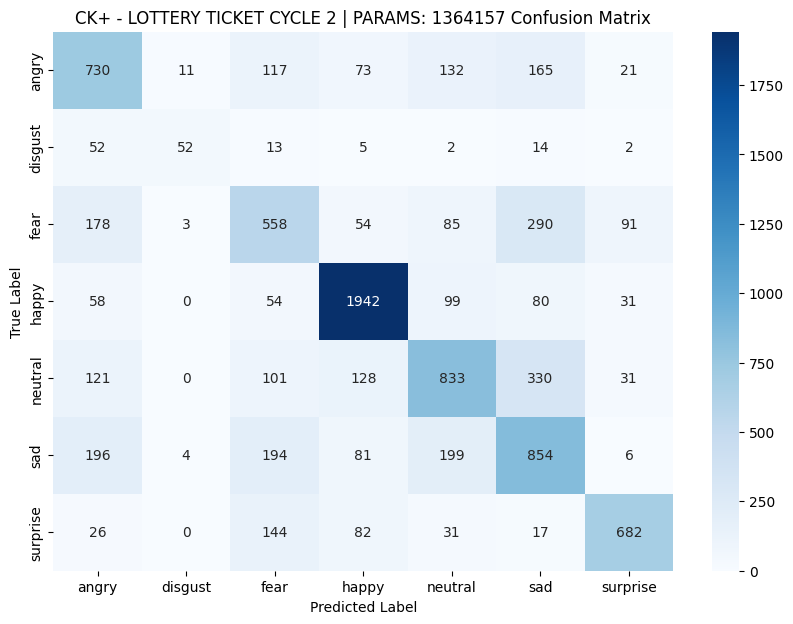

Test Accuracy: 0.6298
Precision: 0.6362
Recall: 0.5782
F1 Score: 0.5971
Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.58      0.56      1249
     disgust       0.74      0.37      0.50       140
        fear       0.47      0.44      0.46      1259
       happy       0.82      0.86      0.84      2264
     neutral       0.60      0.54      0.57      1544
         sad       0.49      0.56      0.52      1534
    surprise       0.79      0.69      0.74       982

    accuracy                           0.63      8972
   macro avg       0.64      0.58      0.60      8972
weighted avg       0.63      0.63      0.63      8972



/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating model from cycle 3, Parameters: 1228348, Min Val Loss: 1.0190


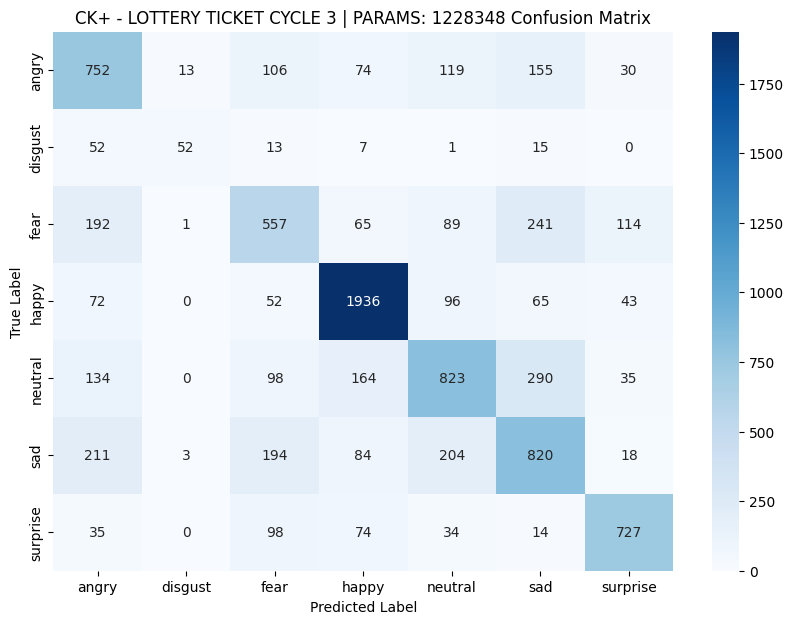

Test Accuracy: 0.6316
Precision: 0.6348
Recall: 0.5827
F1 Score: 0.5983
Classification Report:
               precision    recall  f1-score   support

       angry       0.52      0.60      0.56      1249
     disgust       0.75      0.37      0.50       140
        fear       0.50      0.44      0.47      1259
       happy       0.81      0.86      0.83      2264
     neutral       0.60      0.53      0.57      1544
         sad       0.51      0.53      0.52      1534
    surprise       0.75      0.74      0.75       982

    accuracy                           0.63      8972
   macro avg       0.63      0.58      0.60      8972
weighted avg       0.63      0.63      0.63      8972

Evaluating model from cycle 4, Parameters: 1106117, Min Val Loss: 1.0118


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


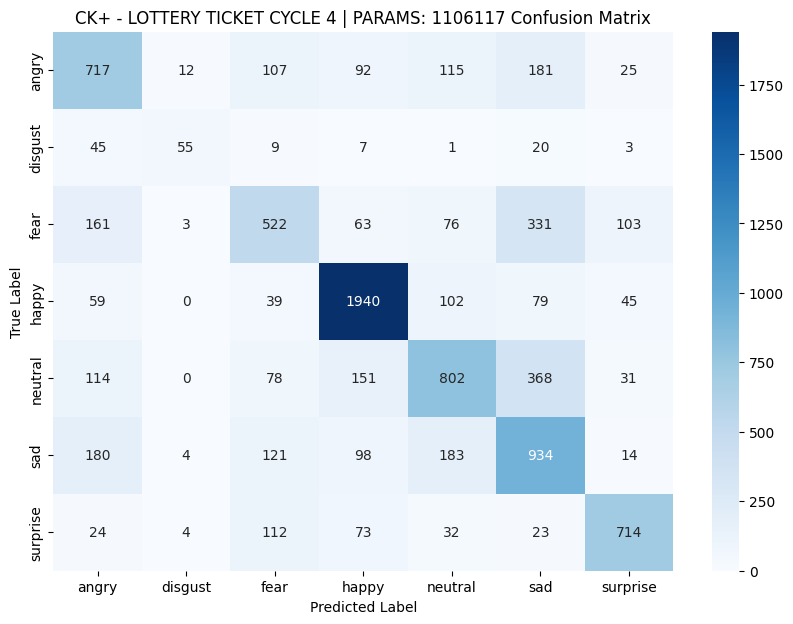

Test Accuracy: 0.6335
Precision: 0.6347
Recall: 0.5848
F1 Score: 0.6006
Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.57      0.56      1249
     disgust       0.71      0.39      0.50       140
        fear       0.53      0.41      0.46      1259
       happy       0.80      0.86      0.83      2264
     neutral       0.61      0.52      0.56      1544
         sad       0.48      0.61      0.54      1534
    surprise       0.76      0.73      0.74       982

    accuracy                           0.63      8972
   macro avg       0.63      0.58      0.60      8972
weighted avg       0.64      0.63      0.63      8972

Evaluating model from cycle 5, Parameters: 996107, Min Val Loss: 1.0199


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


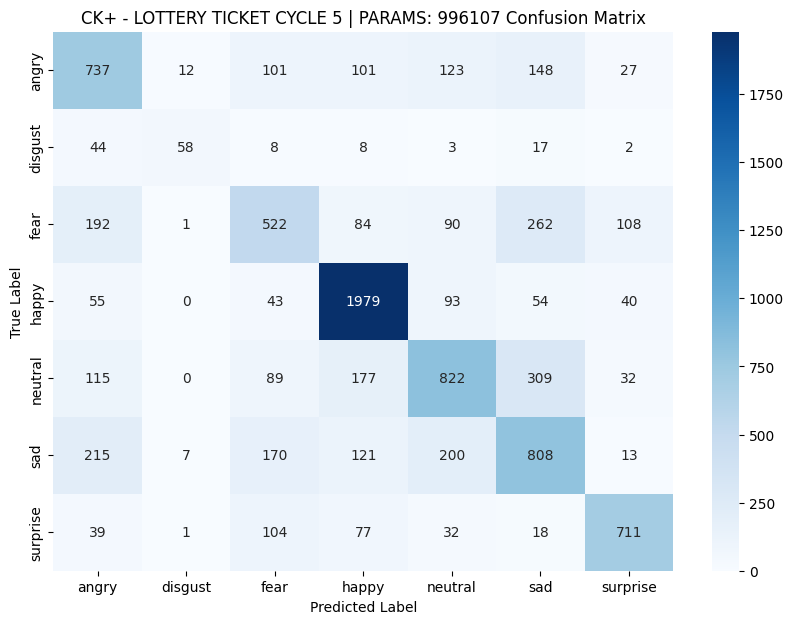

Test Accuracy: 0.6283
Precision: 0.6296
Recall: 0.5823
F1 Score: 0.5979
Classification Report:
               precision    recall  f1-score   support

       angry       0.53      0.59      0.56      1249
     disgust       0.73      0.41      0.53       140
        fear       0.50      0.41      0.45      1259
       happy       0.78      0.87      0.82      2264
     neutral       0.60      0.53      0.57      1544
         sad       0.50      0.53      0.51      1534
    surprise       0.76      0.72      0.74       982

    accuracy                           0.63      8972
   macro avg       0.63      0.58      0.60      8972
weighted avg       0.62      0.63      0.62      8972

Evaluating model from cycle 6, Parameters: 897098, Min Val Loss: 1.0310


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


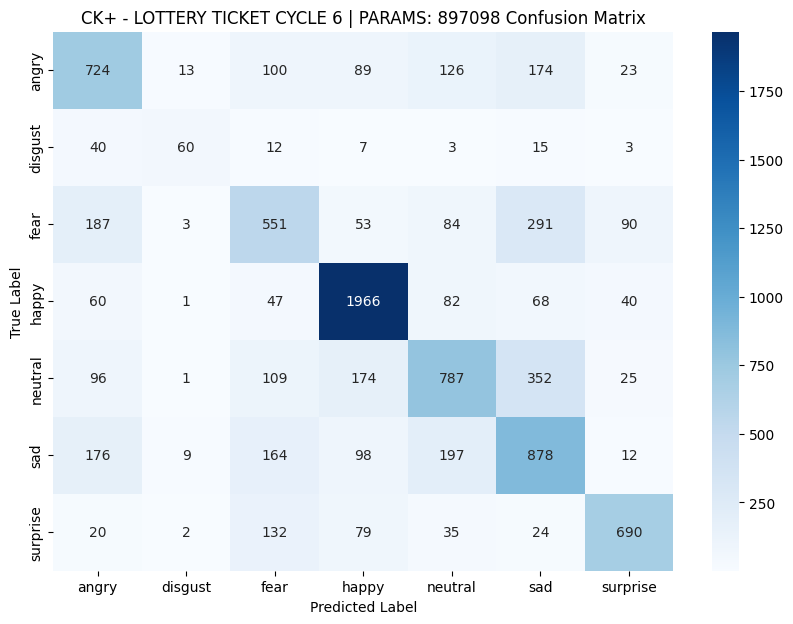

Test Accuracy: 0.6304
Precision: 0.6270
Recall: 0.5856
F1 Score: 0.6006
Classification Report:
               precision    recall  f1-score   support

       angry       0.56      0.58      0.57      1249
     disgust       0.67      0.43      0.52       140
        fear       0.49      0.44      0.46      1259
       happy       0.80      0.87      0.83      2264
     neutral       0.60      0.51      0.55      1544
         sad       0.49      0.57      0.53      1534
    surprise       0.78      0.70      0.74       982

    accuracy                           0.63      8972
   macro avg       0.63      0.59      0.60      8972
weighted avg       0.63      0.63      0.63      8972

Evaluating model from cycle 7, Parameters: 807994, Min Val Loss: 1.0275


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


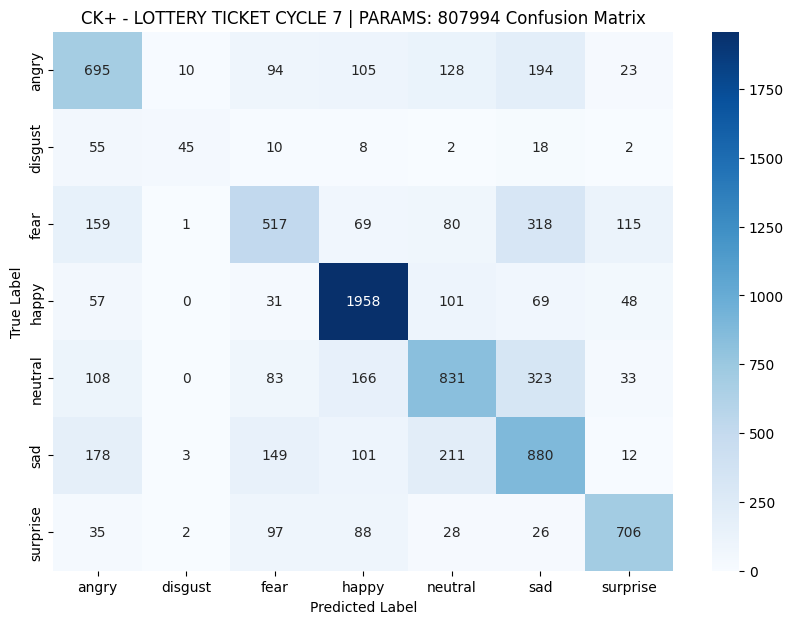

Test Accuracy: 0.6277
Precision: 0.6321
Recall: 0.5692
F1 Score: 0.5867
Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.56      0.55      1249
     disgust       0.74      0.32      0.45       140
        fear       0.53      0.41      0.46      1259
       happy       0.78      0.86      0.82      2264
     neutral       0.60      0.54      0.57      1544
         sad       0.48      0.57      0.52      1534
    surprise       0.75      0.72      0.74       982

    accuracy                           0.63      8972
   macro avg       0.63      0.57      0.59      8972
weighted avg       0.63      0.63      0.62      8972

Evaluating model from cycle 8, Parameters: 727802, Min Val Loss: 1.0230


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


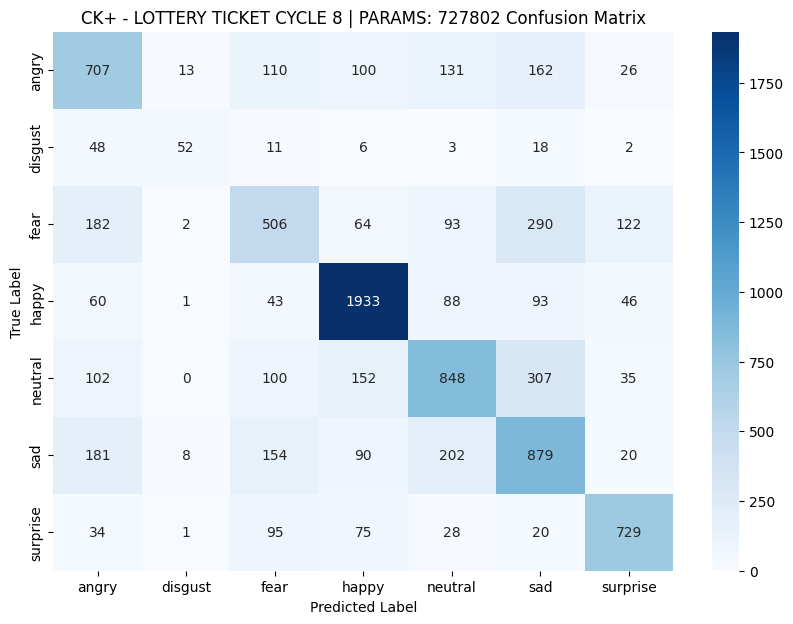

Test Accuracy: 0.6302
Precision: 0.6226
Recall: 0.5797
F1 Score: 0.5933
Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.55      1249
     disgust       0.68      0.37      0.48       140
        fear       0.50      0.40      0.44      1259
       happy       0.80      0.85      0.83      2264
     neutral       0.61      0.55      0.58      1544
         sad       0.50      0.57      0.53      1534
    surprise       0.74      0.74      0.74       982

    accuracy                           0.63      8972
   macro avg       0.62      0.58      0.59      8972
weighted avg       0.63      0.63      0.63      8972

Evaluating model from cycle 9, Parameters: 655622, Min Val Loss: 1.0273


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


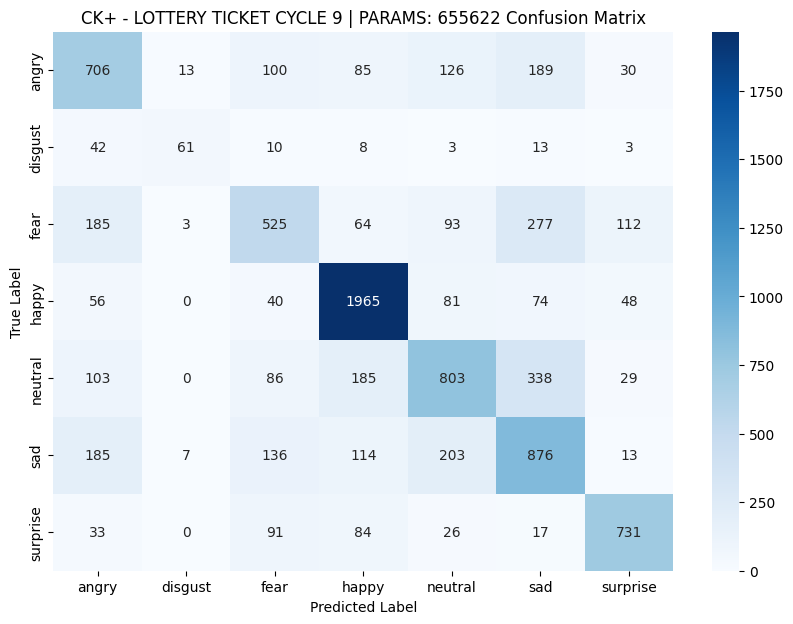

Test Accuracy: 0.6316
Precision: 0.6329
Recall: 0.5888
F1 Score: 0.6035
Classification Report:
               precision    recall  f1-score   support

       angry       0.54      0.57      0.55      1249
     disgust       0.73      0.44      0.54       140
        fear       0.53      0.42      0.47      1259
       happy       0.78      0.87      0.82      2264
     neutral       0.60      0.52      0.56      1544
         sad       0.49      0.57      0.53      1534
    surprise       0.76      0.74      0.75       982

    accuracy                           0.63      8972
   macro avg       0.63      0.59      0.60      8972
weighted avg       0.63      0.63      0.63      8972

Evaluating model from cycle 10, Parameters: 590669, Min Val Loss: 1.0410


/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


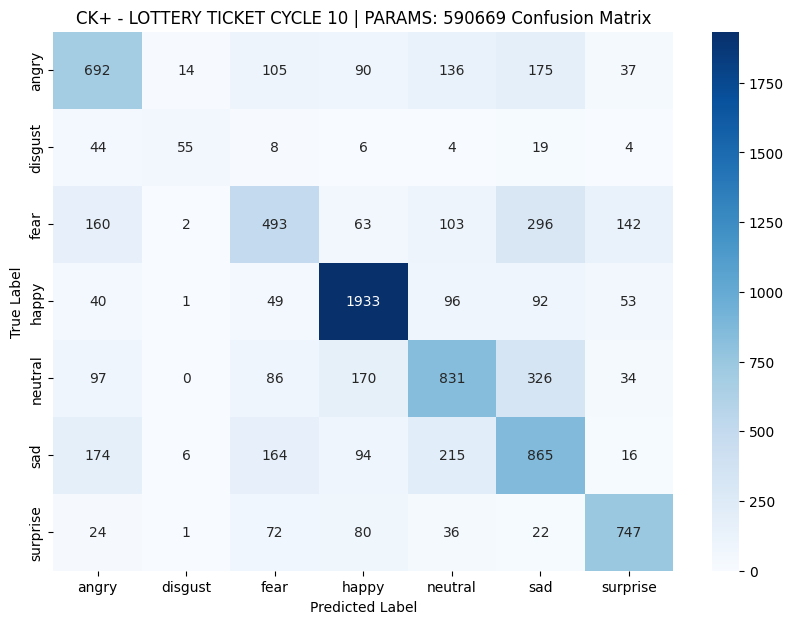

Test Accuracy: 0.6259
Precision: 0.6209
Recall: 0.5793
F1 Score: 0.5922
Classification Report:
               precision    recall  f1-score   support

       angry       0.56      0.55      0.56      1249
     disgust       0.70      0.39      0.50       140
        fear       0.50      0.39      0.44      1259
       happy       0.79      0.85      0.82      2264
     neutral       0.58      0.54      0.56      1544
         sad       0.48      0.56      0.52      1534
    surprise       0.72      0.76      0.74       982

    accuracy                           0.63      8972
   macro avg       0.62      0.58      0.59      8972
weighted avg       0.62      0.63      0.62      8972



In [13]:
def evaluate_all_models(best_models_dict, test_loader, device, data, label_encoder=None):
    for cycle, model_info in best_models_dict.items():
        model_state_dict = model_info['model']
        params = model_info['params']
        min_val_loss = model_info['min_val_loss']

        model = MobileNetV3(num_labels=len(label_encoder.classes_)).to(device)
        model.load_state_dict(model_state_dict)

        title = f'{data.upper()} - Lottery Ticket Cycle {cycle} | Params: {params}'

        print(f"Evaluating model from cycle {cycle}, Parameters: {params}, Min Val Loss: {min_val_loss:.4f}")

        evaluate_model(model, test_loader, device, title, label_encoder=label_encoder)


evaluate_all_models(best_models_dict, test_loader, device, data="CK+", label_encoder=label_encoder)


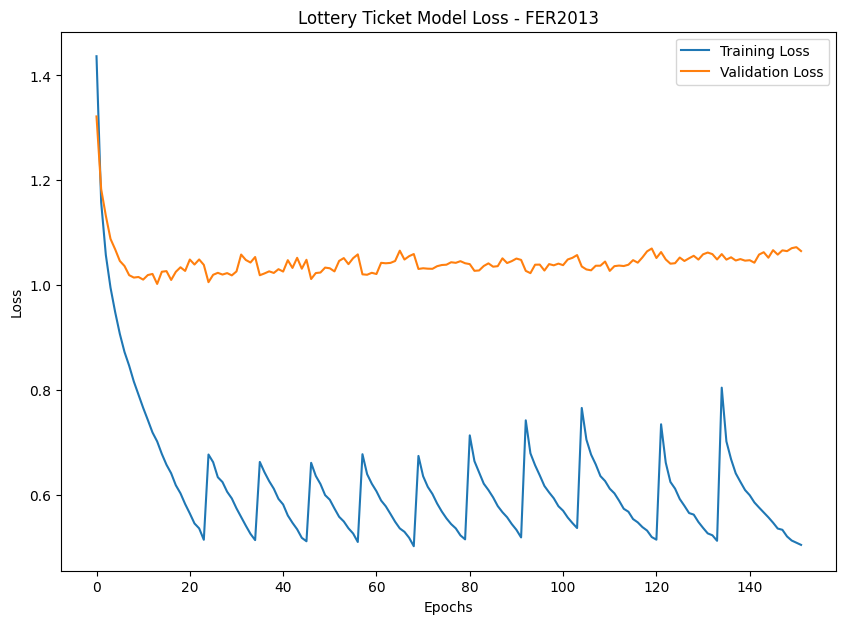

In [14]:
plot_losses(train_loss, 
            val_loss, 
            f'Lottery Ticket Model Loss - {data.upper()}')

In [16]:
min(train_loss)

0.5023571046172192

In [17]:
min(val_loss)

1.0024310012092794